![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import regex as re
from datetime import datetime, timedelta

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [7]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [8]:
df.columns = ['id', 'city', 'cuisine', 'rank',
'price', 'reviews_n', 'reviews', 'url', 'id_ta', 'sample', 'Rating']

In [9]:
df.head(1)

,id,city,cuisine,rank,price,reviews_n,reviews,url,id_ta,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0


# Preprocessing

## 1. reviews_n

In [10]:
len(df.reviews_n[~df.reviews_n.isna()])

46800

In [11]:
df.reviews_n.describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: reviews_n, dtype: float64

25-й перцентиль: 9.0, 75-й перцентиль: 115.0, I: 106.0,  Границы выбросов: [-150.0, 274.0].


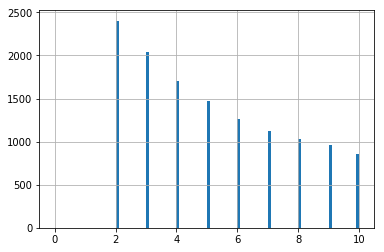

In [12]:
I = df.reviews_n.quantile(0.75) - df.reviews_n.quantile(0.25)
perc25 = df.reviews_n.quantile(0.25)
perc75 = df.reviews_n.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "I: {}, ".format(I), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*I, l=perc75 + 1.5*I))
 
df.reviews_n.loc[df.reviews_n.between(perc25 - 1.5*I, perc75 + 1.5*I)].hist(bins = 100, range = (0, 10), label = 'I')

In [13]:
df.reviews_n.fillna(124, inplace=True) # use mean to fill na
df['reviews_n'] = df['reviews_n'].apply(lambda x: 124 if x > 274 else x) # use mean for outliers
len(df.reviews_n[~df.reviews_n.isna()])

50000

## 2. cuisine

In [14]:
df['cuisine'].fillna(value="change",inplace=True) 
df['cuisine'] = df['cuisine'].apply(lambda x: x[1:-1] if x !="change" else x)
df['cuisine'] = df['cuisine'].apply(lambda x: x.replace("'", "")  if x!="change" else x)
df['cuisine'] = df['cuisine'].apply(lambda x: x.replace(" ", "")  if x!="change" else x)
df['cuisine'] = df['cuisine'].apply(lambda x: x.split(",") if x !="change" else x)

In [15]:
df['cuisine'] = df['cuisine'].apply(lambda x: "VegetarianFriendly" if x =="change" else x)

In [16]:
c = [] 
for i in df.cuisine:
    if i!="change":
        c.append(len(i))
    else:
        c.append(1)
df['cuisine_n'] = c #new category (number of cuisine)

In [17]:
dat = df.explode("cuisine")

a = set()
for x in dat.cuisine:
    if x != "change":
        a.add(x)

cuisine_list = list(a)

def find_cuisine(cell): 
    if cuisine in cell:
        return 1
    return 0

for cuisine in cuisine_list:
    df[cuisine] = df['cuisine'].apply(find_cuisine)
    
df.head(2)

,id,city,cuisine,rank,price,reviews_n,reviews,url,id_ta,sample,...,Armenian,Georgian,Jamaican,Lebanese,Cafe,International,Sushi,Cuban,Swedish,Contemporary
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"[European, Scandinavian, GlutenFreeOptions, Ve...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df.drop(columns=["cuisine"],axis=1,inplace=True)

## 3. price

In [19]:
df['price'] = df['price'].apply(lambda x: 0 if x == '$' else 1 if x=='$$ - $$$' else 2 if x=='$$$$' else x)
'''$           0
   $$ - $$$    1
   $$$$        2'''

'$           0\n   $$ - $$$    1\n   $$$$        2'

In [20]:
df['price'].fillna(value=1,inplace=True) # most common

In [21]:
df[df['price']==2] = 0  # more representative reatures

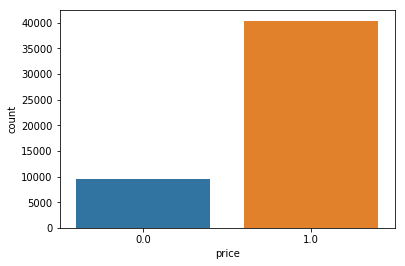

In [22]:
 e = sns.countplot(x=df.price,data=df)

## 4. city

In [23]:
df.city.value_counts()

London        6917
Paris         5825
Madrid        3692
Barcelona     3291
Berlin        2649
Milan         2587
Rome          2491
0             1782
Prague        1774
Lisbon        1603
Vienna        1404
Amsterdam     1331
Brussels      1265
Hamburg       1153
Lyon          1093
Munich        1091
Stockholm     1001
Budapest       993
Warsaw         893
Dublin         819
Copenhagen     782
Athens         752
Edinburgh      726
Zurich         638
Oporto         624
Krakow         541
Geneva         538
Oslo           456
Helsinki       456
Bratislava     366
Luxembourg     252
Ljubljana      215
Name: city, dtype: int64

In [24]:
df['city'] = df['city'].apply(lambda x: 'London' if x ==0 else x) #most common

In [25]:
a = set()
for x in df.city:
    a.add(x)
print(a)

{'Edinburgh', 'Lisbon', 'Milan', 'Zurich', 'Helsinki', 'Barcelona', 'Dublin', 'Prague', 'Athens', 'Stockholm', 'London', 'Munich', 'Madrid', 'Amsterdam', 'Oslo', 'Hamburg', 'Brussels', 'Oporto', 'Rome', 'Luxembourg', 'Vienna', 'Berlin', 'Geneva', 'Budapest', 'Warsaw', 'Bratislava', 'Krakow', 'Ljubljana', 'Paris', 'Lyon', 'Copenhagen'}


In [26]:
city_list = list(a)

def find_city(cell): 
    if city in cell:
        return 1
    return 0

for city in city_list:
    df[city] = df['city'].apply(find_city)
    
df.drop(columns=["city"],axis=1,inplace=True)    
df.head(2)

,id,rank,price,reviews_n,reviews,url,id_ta,sample,Rating,cuisine_n,...,Berlin,Geneva,Budapest,Warsaw,Bratislava,Krakow,Ljubljana,Paris,Lyon,Copenhagen
0,id_0,12963.0,1.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,...,0,0,0,0,0,0,0,1,0,0
1,id_1,106.0,1.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,...,0,0,0,0,0,0,0,0,0,0


## 5. reviews

In [27]:
df['reviews'].describe

<bound method NDFrame.describe of 0                                                 [[], []]
1        [['Very good reviews!', 'Fine dining in Hakani...
2        [['Better than the Links', 'Ivy Black'], ['12/...
3                                                        0
4                                                        0
                               ...                        
49995    [['The real Italian experience!', 'Wonderful f...
49996    [['Parisian atmosphere', 'Bit pricey but inter...
49997    [['Good by swedish standards', 'A hidden jewel...
49998    [['Underground restaurant', 'Oldest Restaurant...
49999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: reviews, Length: 50000, dtype: object>

In [28]:
df['reviews'] = df['reviews'].apply(lambda x: str(x))

In [29]:
df['reviews'] = df['reviews'].apply(lambda x: x.replace("[",""))
df['reviews'] = df['reviews'].apply(lambda x: x.replace("]",""))
df['reviews'] = df['reviews'].apply(lambda x: x.replace("'",""))
df['reviews'] = df['reviews'].apply(lambda x: x.replace("/","."))

In [30]:
df.reviews.fillna('01.01.2011',inplace=True)

In [31]:
data_1 = [] # searching dates
data_2 = []
for i in df.reviews:
    if re.search(r'\d+.\d+.\d+', i):
        result = re.findall(r'\d+.\d+.\d+', i)
        data_1.append(result[0])
        if len(result)>=2:
            data_2.append(result[1])
        else:
            data_2.append(result[0])
    else:
        data_1.append('01.01.2011')
        data_2.append('01.01.2011')

df['data_1'] = data_1
df['data_2'] = data_2

In [32]:
d1 = [] #change format
for i in df.data_1:
    try:
        x = datetime.strptime(i, '%m.%d.%Y')
        d1.append(x)
    except ValueError:
        d1.append(datetime.strptime('01.01.2011','%m.%d.%Y'))
d2 = []
for i in df.data_2:
    try:
        x = datetime.strptime(i, '%m.%d.%Y')
        d2.append(x)
    except ValueError:
        d2.append(datetime.strptime('01.01.2011','%m.%d.%Y'))
                
df['data_1'] = d1
df['data_2'] = d2

In [33]:
ex = df['data_1'][3] #presenting data as number of days 
new = []
for i in range (0,len(df['data_1'])):
    if df['data_1'][i] != ex and df['data_1'][i] != ex:
        new.append(abs(df['data_1'][i] - df['data_2'][i]))
    else:
        new.append(0)
        
new1 = []
for i in new:
    if i != 0:
        element = i// np.timedelta64(1, 'D')
        new1.append(int(element))
    else:
        new1.append(0)

df['range'] = new1 

In [34]:
total = datetime(1970, 1, 1) # number of days in different representation
d_1 = []
for i in d1:
    elem = (i - total).total_seconds() 
    elem = elem/360/24/100
    d_1.append(int(elem))
d_2 = []
for i in d2:
    elem = (i - total).total_seconds()
    elem = elem/360/24/100
    d_2.append(int(elem))  
    
df['data_1'] = d_1
df['data_2'] = d_2

In [35]:
df.corr()>0.7 # High corr between data_1 and data_2. data_2 will be dropped.

,rank,price,reviews_n,sample,Rating,cuisine_n,Halal,Australian,Healthy,Peruvian,...,Warsaw,Bratislava,Krakow,Ljubljana,Paris,Lyon,Copenhagen,data_1,data_2,range
rank,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
reviews_n,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sample,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Rating,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lyon,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
Copenhagen,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
data_1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
data_2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


## 6. delet columns

In [36]:
df.columns

Index(['id', 'rank', 'price', 'reviews_n', 'reviews', 'url', 'id_ta', 'sample',
       'Rating', 'cuisine_n',
       ...
       'Warsaw', 'Bratislava', 'Krakow', 'Ljubljana', 'Paris', 'Lyon',
       'Copenhagen', 'data_1', 'data_2', 'range'],
      dtype='object', length=169)

In [37]:
df.drop(labels=['reviews', 'url', 'id_ta','data_2'],inplace=True,axis=1)
df.head(1)

,id,rank,price,reviews_n,sample,Rating,cuisine_n,Halal,Australian,Healthy,...,Budapest,Warsaw,Bratislava,Krakow,Ljubljana,Paris,Lyon,Copenhagen,data_1,range
0,id_0,12963.0,1.0,4.0,0,0.0,2,0,0,0,...,0,0,0,0,0,1,0,0,1497,0


In [38]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating', 'id'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [39]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [40]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((11423, 164), (38577, 164), (38577, 162), (30861, 162), (7716, 162))

# Model 
Сам ML

In [41]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [42]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [43]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [44]:
y_pred

array([3.785, 4.035, 4.42 , ..., 4.37 , 4.515, 3.965])

In [45]:
a = y_pred/0.5
a = a.round()
y_pred = a*0.5
y_pred

array([4. , 4. , 4.5, ..., 4.5, 4.5, 4. ])

In [46]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.18805080352514256


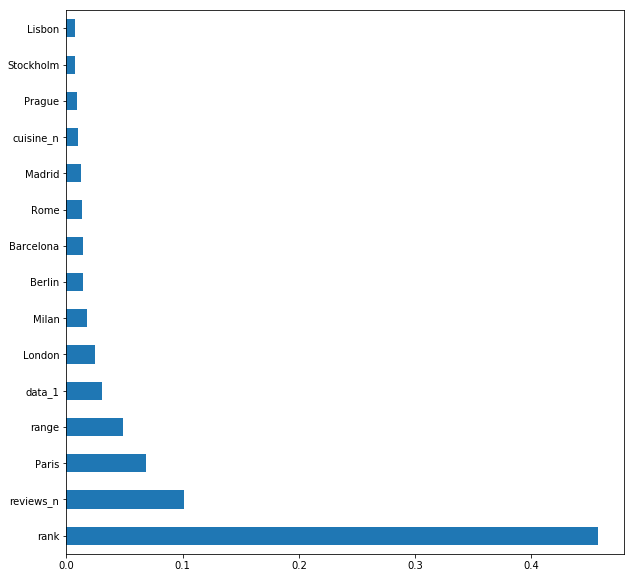

In [47]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [48]:
test_data.sample(10)

,id,rank,price,reviews_n,Rating,cuisine_n,Halal,Australian,Healthy,Peruvian,...,Budapest,Warsaw,Bratislava,Krakow,Ljubljana,Paris,Lyon,Copenhagen,data_1,range
1456,id_1456,2366.0,1.0,124.0,0.0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,1742,80
15805,0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1497,0
9284,0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1497,0
9849,id_9849,1985.0,0.0,7.0,0.0,2,0,0,0,0,...,1,0,0,0,0,0,0,0,1719,245
8329,id_8329,932.0,1.0,124.0,0.0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,1753,2
6287,id_6287,11040.0,1.0,104.0,0.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1637,0
14170,0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1497,0
27288,0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1497,0
9887,id_9887,5107.0,1.0,124.0,0.0,18,0,0,0,0,...,0,0,0,0,0,0,0,0,1497,0
4717,id_4717,1050.0,1.0,89.0,0.0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,1747,62


In [49]:
test_data = test_data.drop(['Rating', 'id'], axis=1)

In [50]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [51]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [52]:
predict_submission

array([3.075, 4.205, 4.355, ..., 4.795, 4.795, 4.795])

In [53]:
len(predict_submission)

11423

In [54]:
predicted = predict_submission[0:10000]
predicted

array([3.075, 4.205, 4.355, ..., 3.   , 4.41 , 4.26 ])

In [55]:
len(predicted)

10000

In [56]:
a = predicted/0.5
a = a.round()
predicted = a*0.5
predicted

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [57]:
sample_submission['Rating'] = predicted
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,5.0
4,id_4,5.0
5,id_5,4.5
6,id_6,2.0
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
